# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [1]:
import sys
sys.path.append('../') # Use parent dir.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import json
from datetime import datetime
import numpy as np

2024-04-11 13:50:16.851922: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
output_dir = Path('./output/')
root_dir = output_dir/'coingame_maa2c_classical_mdp'
root_dir.expanduser().mkdir(parents=True, exist_ok=True)

checkpoint_dir = root_dir / 'checkpoints'

metrics_file = root_dir / 'metrics-{datetime}.json'
model_actor_checkpoint_file = checkpoint_dir / 'actor' / 'cp-{datetime}.ckpt'
model_critic_checkpoint_file = checkpoint_dir / 'critic' / 'cp-{datetime}.ckpt'

In [6]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [7]:
def generate_model_actor_classical(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

def generate_model_critic_classical(units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [8]:
# Shared actor.
model_actor = generate_model_actor_classical(
    n_actions=n_actions,
    units=[12],
    name=f"actor-classical-shared"
    )
optimizer_actor = keras.optimizers.Adam(learning_rate=1e-3)

model_actor.build((None, observation_dim))
model_actor.summary()

Model: "actor-classical-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 12)                444       
                                                                 
 policy (Dense)              (None, 4)                 52        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Classical critic.
model_critic = generate_model_critic_classical(
    units=[12],
    name=f"critic-classical-joint"
    )
optimizer_critic = keras.optimizers.Adam(learning_rate=1e-3)

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "critic-classical-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                876       
                                                                 
 v (Dense)                   (None, 1)                 13        
                                                                 
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


## Training

In [10]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [11]:
# Time of training start.
datetime_start = datetime.now().isoformat()

# Set model checkpoint files to have timestamp of training start.
model_actor_checkpoint_file_current = str(model_actor_checkpoint_file).format(datetime=datetime_start)
model_critic_checkpoint_file_current = str(model_critic_checkpoint_file).format(datetime=datetime_start)
metrics_file_current = str(metrics_file).format(datetime=datetime_start)

# Train models using algorithm.
reward_history, metrics_history = algo.train(
    n_episodes=3000,
    callbacks=[
        eqmarl.AlgorithmResultCheckpoint(filepath=metrics_file_current, save_freq=100, verbose=True),
        ],
    )

# Save results to file.
algo.save_train_results(metrics_file_current, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 101:   3%|▎         | 101/3000 [00:13<06:29,  7.45episode/s, coins_collected=6, discounted_reward=1.77, episode_reward=[ 4. -2.], own_coin_rate=0.667, own_coins_collected=4, undiscounted_reward=2]  

Saving results at episode 100 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 201:   7%|▋         | 201/3000 [00:26<06:06,  7.63episode/s, coins_collected=11, discounted_reward=-.579, episode_reward=[-3.  2.], own_coin_rate=0.455, own_coins_collected=5, undiscounted_reward=-1]

Saving results at episode 200 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 301:  10%|█         | 301/3000 [00:40<06:08,  7.33episode/s, coins_collected=5, discounted_reward=4.16, episode_reward=[2. 3.], own_coin_rate=1, own_coins_collected=5, undiscounted_reward=5]         

Saving results at episode 300 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 401:  13%|█▎        | 401/3000 [00:54<05:52,  7.38episode/s, coins_collected=11, discounted_reward=-.809, episode_reward=[-1.  0.], own_coin_rate=0.455, own_coins_collected=5, undiscounted_reward=-1]

Saving results at episode 400 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 501:  17%|█▋        | 501/3000 [01:07<06:03,  6.87episode/s, coins_collected=9, discounted_reward=1.36, episode_reward=[ 7. -6.], own_coin_rate=0.556, own_coins_collected=5, undiscounted_reward=1]     

Saving results at episode 500 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 601:  20%|██        | 601/3000 [01:21<05:30,  7.27episode/s, coins_collected=2, discounted_reward=1.57, episode_reward=[0. 2.], own_coin_rate=1, own_coins_collected=2, undiscounted_reward=2]         

Saving results at episode 600 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 701:  23%|██▎       | 701/3000 [01:35<04:53,  7.84episode/s, coins_collected=5, discounted_reward=1.91, episode_reward=[0. 3.], own_coin_rate=0.8, own_coins_collected=4, undiscounted_reward=3]       

Saving results at episode 700 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 801:  27%|██▋       | 801/3000 [01:48<04:45,  7.71episode/s, coins_collected=4, discounted_reward=1.53, episode_reward=[ 3. -1.], own_coin_rate=0.75, own_coins_collected=3, undiscounted_reward=2]      

Saving results at episode 800 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 901:  30%|███       | 901/3000 [02:03<05:00,  6.98episode/s, coins_collected=6, discounted_reward=2.74, episode_reward=[-1.  5.], own_coin_rate=0.833, own_coins_collected=5, undiscounted_reward=4]  

Saving results at episode 900 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1001:  33%|███▎      | 1001/3000 [02:17<04:33,  7.30episode/s, coins_collected=7, discounted_reward=1.11, episode_reward=[-4.  5.], own_coin_rate=0.571, own_coins_collected=4, undiscounted_reward=1]  

Saving results at episode 1000 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1101:  37%|███▋      | 1101/3000 [02:32<04:12,  7.51episode/s, coins_collected=14, discounted_reward=6.11, episode_reward=[7. 1.], own_coin_rate=0.786, own_coins_collected=11, undiscounted_reward=8]  

Saving results at episode 1100 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1201:  40%|████      | 1201/3000 [02:45<04:30,  6.66episode/s, coins_collected=7, discounted_reward=2.25, episode_reward=[2. 1.], own_coin_rate=0.714, own_coins_collected=5, undiscounted_reward=3]    

Saving results at episode 1200 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1301:  43%|████▎     | 1301/3000 [03:00<04:29,  6.31episode/s, coins_collected=14, discounted_reward=7.94, episode_reward=[5. 5.], own_coin_rate=0.857, own_coins_collected=12, undiscounted_reward=10]  

Saving results at episode 1300 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1401:  47%|████▋     | 1401/3000 [03:14<03:41,  7.23episode/s, coins_collected=6, discounted_reward=3.02, episode_reward=[2. 2.], own_coin_rate=0.833, own_coins_collected=5, undiscounted_reward=4]    

Saving results at episode 1400 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1501:  50%|█████     | 1501/3000 [03:28<03:15,  7.67episode/s, coins_collected=12, discounted_reward=9.61, episode_reward=[6. 6.], own_coin_rate=1, own_coins_collected=12, undiscounted_reward=12]    

Saving results at episode 1500 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1601:  53%|█████▎    | 1601/3000 [03:41<03:00,  7.73episode/s, coins_collected=20, discounted_reward=4.49, episode_reward=[3. 3.], own_coin_rate=0.65, own_coins_collected=13, undiscounted_reward=6]    

Saving results at episode 1600 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1701:  57%|█████▋    | 1701/3000 [03:54<03:05,  7.02episode/s, coins_collected=12, discounted_reward=7.74, episode_reward=[4. 6.], own_coin_rate=0.917, own_coins_collected=11, undiscounted_reward=10]  

Saving results at episode 1700 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1801:  60%|██████    | 1801/3000 [04:07<02:41,  7.41episode/s, coins_collected=15, discounted_reward=11.9, episode_reward=[9. 6.], own_coin_rate=1, own_coins_collected=15, undiscounted_reward=15]      

Saving results at episode 1800 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 1901:  63%|██████▎   | 1901/3000 [04:20<02:22,  7.73episode/s, coins_collected=19, discounted_reward=12.8, episode_reward=[10.  7.], own_coin_rate=0.947, own_coins_collected=18, undiscounted_reward=17]

Saving results at episode 1900 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2001:  67%|██████▋   | 2001/3000 [04:33<02:09,  7.71episode/s, coins_collected=20, discounted_reward=15.2, episode_reward=[14.  6.], own_coin_rate=1, own_coins_collected=20, undiscounted_reward=20]    

Saving results at episode 2000 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2101:  70%|███████   | 2101/3000 [04:46<02:00,  7.44episode/s, coins_collected=18, discounted_reward=13.9, episode_reward=[11.  7.], own_coin_rate=1, own_coins_collected=18, undiscounted_reward=18]    

Saving results at episode 2100 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2201:  73%|███████▎  | 2201/3000 [04:59<01:53,  7.04episode/s, coins_collected=23, discounted_reward=16.4, episode_reward=[13.  8.], own_coin_rate=0.957, own_coins_collected=22, undiscounted_reward=21]

Saving results at episode 2200 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2301:  77%|███████▋  | 2301/3000 [05:12<01:32,  7.55episode/s, coins_collected=16, discounted_reward=12.1, episode_reward=[8. 8.], own_coin_rate=1, own_coins_collected=16, undiscounted_reward=16]      

Saving results at episode 2300 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2401:  80%|████████  | 2401/3000 [05:26<01:20,  7.47episode/s, coins_collected=20, discounted_reward=14.1, episode_reward=[ 8. 10.], own_coin_rate=0.95, own_coins_collected=19, undiscounted_reward=18] 

Saving results at episode 2400 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2501:  83%|████████▎ | 2501/3000 [05:39<01:13,  6.77episode/s, coins_collected=26, discounted_reward=17.3, episode_reward=[12. 10.], own_coin_rate=0.923, own_coins_collected=24, undiscounted_reward=22]

Saving results at episode 2500 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2601:  87%|████████▋ | 2601/3000 [05:52<00:57,  6.92episode/s, coins_collected=25, discounted_reward=20, episode_reward=[15. 10.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]      

Saving results at episode 2600 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2701:  90%|█████████ | 2701/3000 [06:07<00:41,  7.23episode/s, coins_collected=20, discounted_reward=15.1, episode_reward=[10. 10.], own_coin_rate=1, own_coins_collected=20, undiscounted_reward=20]    

Saving results at episode 2700 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2801:  93%|█████████▎| 2801/3000 [06:21<00:27,  7.22episode/s, coins_collected=28, discounted_reward=22, episode_reward=[16. 12.], own_coin_rate=1, own_coins_collected=28, undiscounted_reward=28]      

Saving results at episode 2800 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 2901:  97%|█████████▋| 2901/3000 [06:34<00:13,  7.42episode/s, coins_collected=25, discounted_reward=19.7, episode_reward=[12. 13.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 2900 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


Episode 3000: 100%|██████████| 3000/3000 [06:47<00:00,  7.36episode/s, coins_collected=24, discounted_reward=18.3, episode_reward=[11. 13.], own_coin_rate=1, own_coins_collected=24, undiscounted_reward=24]    


Saving results at episode 3000 to file output/coingame_maa2c_classical_mdp/metrics-2024-04-11T13:50:17.627805.json


In [14]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file_current)

Text(0.5, 1.0, 'Score')

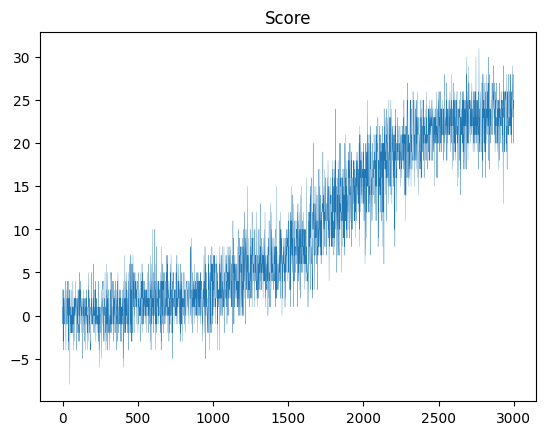

In [39]:
score = np.sum(reward_history, axis=-1)
plt.plot(score, linewidth=.2)
plt.title('Score')

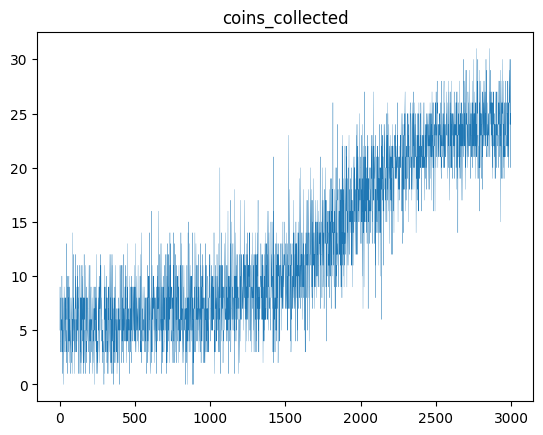

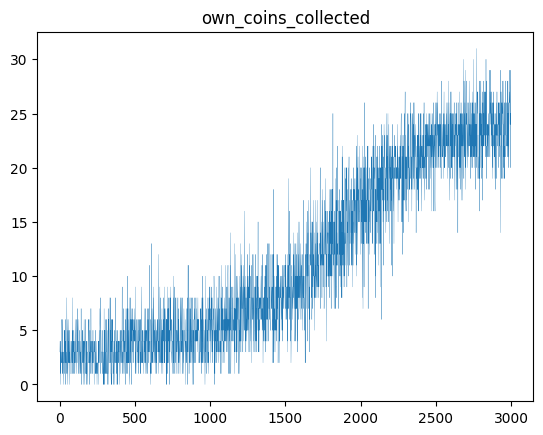

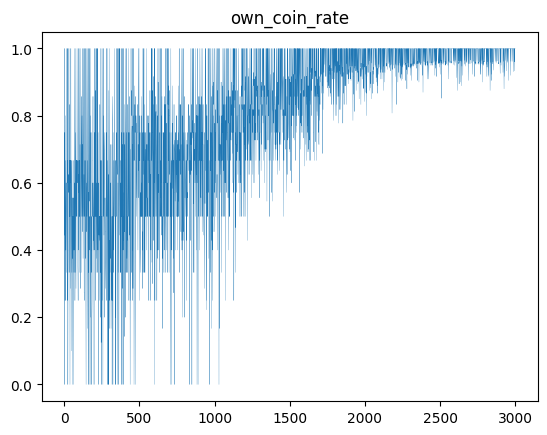

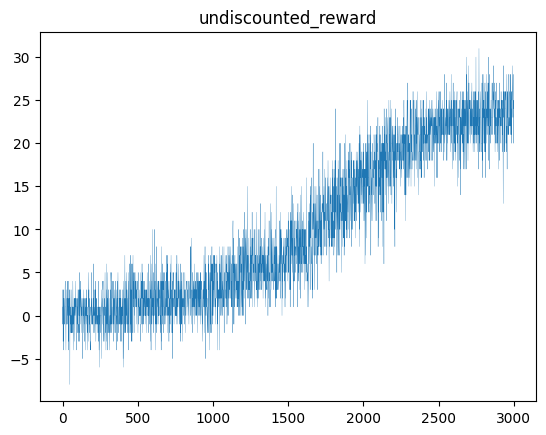

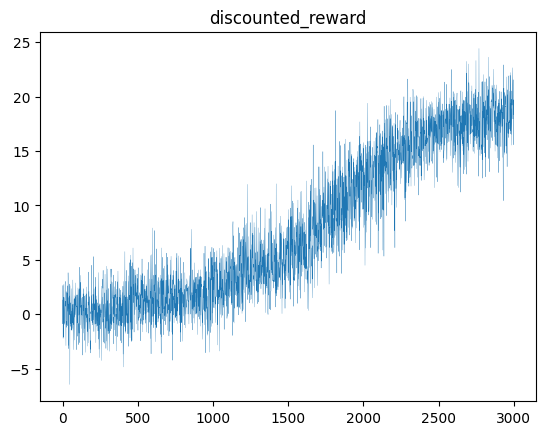

In [40]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v, linewidth=.2)